In [1]:
import MultiScaleOT as MOT
using HDF5
using Plots
# Some plots defaults
default(legend = :none, aspect_ratio = :equal)
using SparseArrays

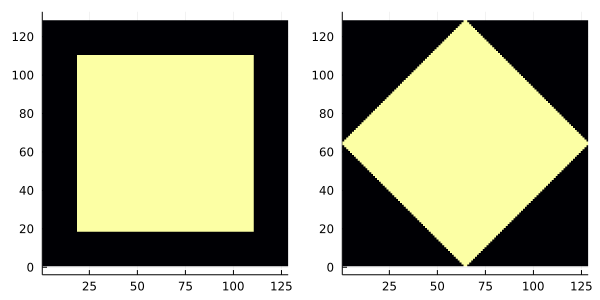

In [2]:
# Load data
img1, img2, shape1, shape2 = h5open("data/square_diamond.hdf5", "r") do file
    (
        read(file, "img1"), read(file, "img2"), 
        read(file, "shape1"), read(file, "shape2")
    )
end

plot(heatmap(img1), heatmap(img2), size = (600, 300))

In [3]:
# Build measures:
# Weights
mu1 = img1[:] .+ 1e-8
mu2 = img2[:] .+ 1e-8

MOT.normalize!(mu1)
MOT.normalize!(mu2)

# Supporting points
x1 = collect(1:128)
X = MOT.flat_grid(x1, x1)
Y = copy(X)

# Gridshapes
shapeX = size(img1)
shapeY = size(img2)

# Measure struct
mu = MOT.GridMeasure(X, mu1, shapeX)
nu = MOT.GridMeasure(Y, mu2, shapeY)

MultiScaleOT.GridMeasure{2}([1.0 2.0 … 127.0 128.0; 1.0 1.0 … 128.0 128.0], [9.998361868391484e-9, 9.998361868391484e-9, 9.998361868391484e-9, 9.998361868391484e-9, 9.998361868391484e-9, 9.998361868391484e-9, 9.998361868391484e-9, 9.998361868391484e-9, 9.998361868391484e-9, 9.998361868391484e-9  …  9.998361868391484e-9, 9.998361868391484e-9, 9.998361868391484e-9, 9.998361868391484e-9, 9.998361868391484e-9, 9.998361868391484e-9, 9.998361868391484e-9, 9.998361868391484e-9, 9.998361868391484e-9, 9.998361868391484e-9], (128, 128))

In [4]:
# Prepare parameters for the solver and multiscale
depth = MOT.compute_multiscale_depth(mu)

c(x,y) = MOT.l22(x,y)

# Epsilon schedule
Nsteps = 3
factor = 2.
eps_target = 0.5
last_iter = [eps_target/2]

# Epsilon scaling
eps_schedule = MOT.scaling_schedule(depth, eps_target, Nsteps, factor; last_iter = last_iter)

layer_schedule = MOT.template_schedule(depth, Nsteps, collect(1:depth); last_iter = [depth])

truncation = 1e-15

params_schedule = MOT.make_schedule(
                layer = layer_schedule,
                solver_eps = eps_schedule, 
                solver_truncation = truncation,
                solver_max_error = 1e-4,
                solver_verbose = true,
                solver_max_iter = 10000
        );

In [5]:
# Solve OT problem hierarchically
@time K, a, b, status = MOT.hierarchical_sinkhorn(mu, nu, c, params_schedule, 2)

Layer	2	eps =	8192.0	status	0	PD gap	-1.3642420526593924e-12
Layer	2	eps =	4096.0	status	0	PD gap	-4.547473508864641e-13
Layer	2	eps =	2048.0	status	0	PD gap	9.094947017729282e-13
Layer	3	eps =	2048.0	status	0	PD gap	0.0
Layer	3	eps =	1024.0	status	0	PD gap	-4.092726157978177e-12
Layer	3	eps =	512.0	status	0	PD gap	9.699828751763562e-6
Layer	4	eps =	512.0	status	0	PD gap	-3.865352482534945e-11
Layer	4	eps =	256.0	status	0	PD gap	6.078646833884704e-6
Layer	4	eps =	128.0	status	0	PD gap	8.201162131626916e-6
Layer	5	eps =	128.0	status	0	PD gap	0.00016017565002357514
Layer	5	eps =	64.0	status	0	PD gap	0.0004170991294927262
Layer	5	eps =	32.0	status	0	PD gap	0.0011405964656603373
Layer	6	eps =	32.0	status	0	PD gap	-0.0005851390357349828
Layer	6	eps =	16.0	status	0	PD gap	0.0012742971223076438
Layer	6	eps =	8.0	status	0	PD gap	0.000880158467992942
Layer	7	eps =	8.0	status	0	PD gap	-0.004707818761332305
Layer	7	eps =	4.0	status	0	PD gap	-0.000524061566011369
Layer	7	eps =	2.0	status	0	PD gap	

(
⣿⣷⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣿⣿⣿⣿⣦⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣿⣿⣿⣿⣿⣿⣷⣶⣤⣀⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠉⠛⠻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠉⠻⢿⣿⣿⣿⣿⣿⣿⣿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠛⢿⣿⣿⣿⣿⣿⣿⣿⣦⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣿⣿⣿⣿⣿⣿⣿⣷⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⢿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣿⣿⣿⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣿⣇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢹⣿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⣿⣿⣿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣷⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢿⣿⣿⣿⣿⣿⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⠻⣿⣿⣿⣿⣿⣿⣿⣷⣤⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣿⣿⣿⣿⣿⣿⣿⣷⣦⣀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⣤⣀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠉⠉⠛⠿⢿⣿⣿⣿⣿⣿⣿
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠻⣿⣿⣿⣿
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⢿⣿, [500.8772254516294, 500.89254953170393, 500.91385446244476, 500.9095517357344, 500.8301187347272, 500.6049016599539, 500.17815516123983, 499.5370690790923, 498.692922324629, 497

In [6]:
# Visualize displacement interpolation
# TODO: Quite messy code right now
function displacement_interpolation(P::SparseMatrixCSC, X, Y, shapeX, t)
    (0 ≤ t ≤ 1) || erorr("t must be in [0,1]")
    # Z = Matrix{Float64}(undef, size(X, 1), length(P.nzval))
    Z = zeros(shapeX...)
    for j in 1:size(P, 2)
        for r in P.colptr[j]:P.colptr[j+1]-1
            i = P.rowval[r]
            k1 = (1-t).*X[1,i] .+ t.*Y[1,j]
            k2 = (1-t).*X[2,i] .+ t.*Y[2,j]
            Z[Int(round(k1)), Int(round(k2))] += P.nzval[r]
        end
    end
    return Z
end

displacement_interpolation (generic function with 1 method)

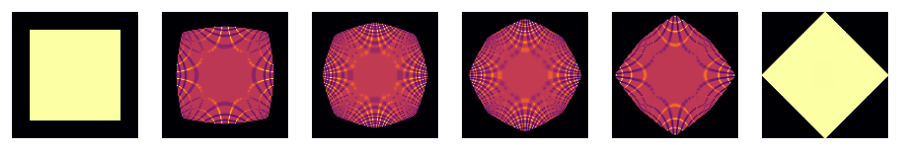

In [7]:
plots = []
for t in 0:0.2:1
    Z = displacement_interpolation(K, X, Y, shape1, t)
    plot_i = heatmap(Z, axis = :off)
    xticks!(Int[])
    yticks!(Int[])
    push!(plots, plot_i)
end
plot(plots..., layout = (1,6), size = (900,150))